In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getCloseDataPandas(ticker, start,end=None):
    print(ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    print(ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    plt.figure(figsize=(15,5))
    plt.plot(-dd, label="DrawDown")
    plt.legend(fontsize = 16)
    mdd = dd.max()
    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn


### 모멘텀 계산 방법

In [3]:
# 데이터 로드 :1년치
kodex200 = getCloseData("069500", "2021-9-1","2022-9-30")
kodex200

069500


Date
2021-09-01    41200
2021-09-02    40823
2021-09-03    41087
2021-09-06    41230
2021-09-07    40984
              ...  
2022-09-26    29050
2022-09-27    29105
2022-09-28    28390
2022-09-29    28400
2022-09-30    28275
Name: Close, Length: 266, dtype: int64

In [4]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(kodex200)
rebalDate

DatetimeIndex(['2021-09-30', '2021-10-29', '2021-11-30', '2021-12-30',
               '2022-01-28', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [5]:
len(rebalDate)

13

In [6]:
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  kodex200.loc[rebalDate]
priceOnRebalDate

Date
2021-09-30    39387
2021-10-29    38126
2021-11-30    36757
2021-12-30    39153
2022-01-28    35656
2022-02-28    36005
2022-03-31    36472
2022-04-29    35433
2022-05-31    35363
2022-06-30    30808
2022-07-29    32385
2022-08-31    32230
2022-09-30    28275
Name: Close, dtype: int64

In [7]:
test = priceOnRebalDate.copy()
result = pd.DataFrame(test, columns=['Close'])

In [8]:
# n개월 모멘텀 한번에 구하기
n= 5

for i in range(len(test)-1,-1,-1):
    tmp =0
    if i<n:
        for j in range(0, i):
            if test[i]>test[j] : tmp = tmp+1
    else:
        for j in range(i-1,i-n-1, -1):
            if test[i]>test[j] : tmp = tmp+1
    result['Close'][i] = tmp


In [9]:
result

,Close
Date,
2021-09-30,0
2021-10-29,0
2021-11-30,0
2021-12-30,2
2022-01-28,0
2022-02-28,1
2022-03-31,2
2022-04-29,0
2022-05-31,0


# 함수화 1 - 단일 모멘텀 구하기 

In [3]:
def avgMomentumScoretable1(data, n):
    result = pd.DataFrame(data, columns=['Close'])
    
    for i in range(len(data)-1,-1,-1):
        tmp =0
        if i<n:
            for j in range(0, i):
                if data[i]>data[j] : tmp = tmp+1
        else:
            for j in range(i-1,i-n-1, -1):
                if data[i]>data[j] : tmp = tmp+1
        result['Close'][i] = tmp
    
    return result

In [11]:
test = getCloseData("069500", "1986", "2014") # 코스피200 ETF


result12 = avgMomentumScoretable1(test,12)
result11 = avgMomentumScoretable1(test,11)
result10 = avgMomentumScoretable1(test,10)
result9 = avgMomentumScoretable1(test,9)
result8 = avgMomentumScoretable1(test,8)
result7 = avgMomentumScoretable1(test,7)
result6 = avgMomentumScoretable1(test,6)
result5 = avgMomentumScoretable1(test,5)
result4 = avgMomentumScoretable1(test,4)
result3 = avgMomentumScoretable1(test,3)
result2 = avgMomentumScoretable1(test,2)
result1 = avgMomentumScoretable1(test,1)


069500


In [12]:
result12

,Close
Date,
2002-10-14,0
2002-10-15,1
2002-10-16,2
2002-10-17,3
2002-10-18,4
...,...
2013-12-23,12
2013-12-24,12
2013-12-26,11


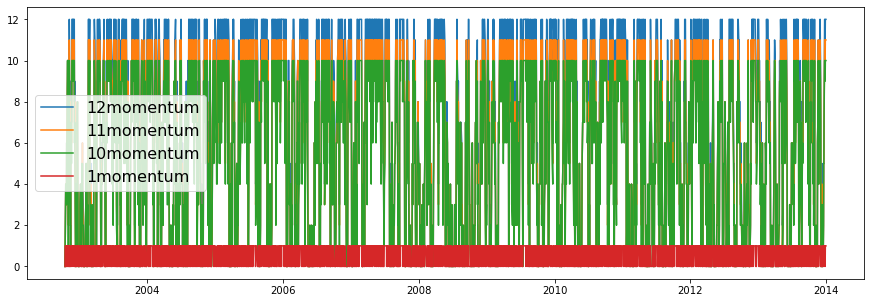

In [16]:
plt.figure(figsize=(15,5))
plt.plot(result12, label="12momentum")
plt.plot(result11, label="11momentum")
plt.plot(result10, label="10momentum")
plt.plot(result1, label="1momentum")

plt.legend(fontsize = 16)

# 함수화 2 - 다중

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
    result = pd.DataFrame(data)

    if len(result.columns) ==1 :   
        result.columns = [name+"_m"]

        for i in range(len(data)-1,-1,-1):
            tmp =0
            if i<n:
                for j in range(0, i):
                    if data[i]>data[j] : tmp = tmp+1
            else:
                for j in range(i-1,i-n-1, -1):
                    if data[i]>data[j] : tmp = tmp+1
            result[name+"_m"][i] = tmp
    else :
        name_list = result.columns
        for i in range(0, len(name_list)):
            result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
            result = result.drop([name_list[i]], axis=1)
        result.columns = name_list

    return  result

In [30]:
def weightScore(data):
    weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)

    return weight

In [28]:
# 데이터 로드
kodex200 = getCloseData("069500", "2020", "2022-7-30") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2020", "2022-7-30") # kodex 국고채 10년물 etf

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)

# 리밸런싱 일자
rebalDate = getRebalancingDate(closeDataSet)
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  closeDataSet.loc[rebalDate]
priceOnRebalDate


069500
152380


,kodex200,kodex10Bond
Date,,
2020-01-31,27231,71380
2020-02-28,25650,72870
2020-03-31,22720,71410
2020-04-29,24766,71690
2020-05-29,25681,72630
2020-06-30,26923,72695
2020-07-31,28758,73280
2020-08-31,29542,71985
2020-09-29,29869,72510


In [29]:
avgMomentumScore= avgMomentumScoretable(priceOnRebalDate, 6)
avgMomentumScore

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,0.166667
2020-03-31,0.000000,0.166667
2020-04-29,0.166667,0.333333
2020-05-29,0.500000,0.500000
2020-06-30,0.666667,0.666667
2020-07-31,1.000000,1.000000
2020-08-31,1.000000,0.333333
2020-09-29,1.000000,0.500000


In [31]:
weight = weightScore(avgMomentumScore)
weight

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.750000,0.250000,0
2020-09-29,0.666667,0.333333,0


In [35]:
avgMomentumScore6 = avgMomentumScoretable(priceOnRebalDate, n=6)
weight6 = weightScore(avgMomentumScore6)

In [36]:
avgMomentumScore12 = avgMomentumScoretable(priceOnRebalDate, n=12)
weight12 = weightScore(avgMomentumScore12)

In [39]:
avgMomentumScore6

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,0.166667
2020-03-31,0.000000,0.166667
2020-04-29,0.166667,0.333333
2020-05-29,0.500000,0.500000
2020-06-30,0.666667,0.666667
2020-07-31,1.000000,1.000000
2020-08-31,1.000000,0.333333
2020-09-29,1.000000,0.500000


In [40]:
avgMomentumScore12

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,0.083333
2020-03-31,0.000000,0.083333
2020-04-29,0.083333,0.166667
2020-05-29,0.250000,0.250000
2020-06-30,0.333333,0.333333
2020-07-31,0.500000,0.500000
2020-08-31,0.583333,0.250000
2020-09-29,0.666667,0.333333


In [37]:
weight6

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.750000,0.250000,0
2020-09-29,0.666667,0.333333,0


In [38]:
weight12

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.700000,0.300000,0
2020-09-29,0.666667,0.333333,0


In [41]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [42]:
closeDataSet['cash'] = 1
closeDataSet

,kodex200,kodex10Bond,cash
Date,,,
2020-01-02,27751,70720,1
2020-01-03,27747,71195,1
2020-01-06,27535,71320,1
2020-01-07,27812,70830,1
2020-01-08,27635,70795,1
...,...,...,...
2022-07-25,31910,64485,1
2022-07-26,32025,64640,1
2022-07-27,32035,64900,1


**12개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

12개월 평균 모멘텀 스코어 최종수익률: 1.2440439808159642
최종 수익률 : 1.2440439808159642
cagr: 1.092970420917675
mdd: 19.468388069150798


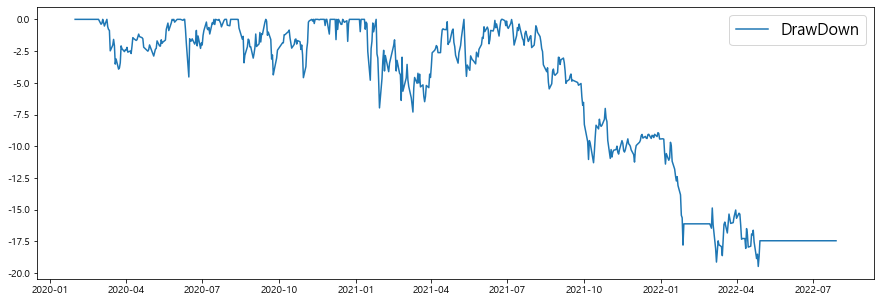

In [49]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)

print(f"12개월 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

**6개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

6개월 평균 모멘텀 스코어 최종수익률: 1.318175246120836
최종 수익률 : 1.318175246120836
cagr: 1.119030847504565
mdd: 15.900267540168095


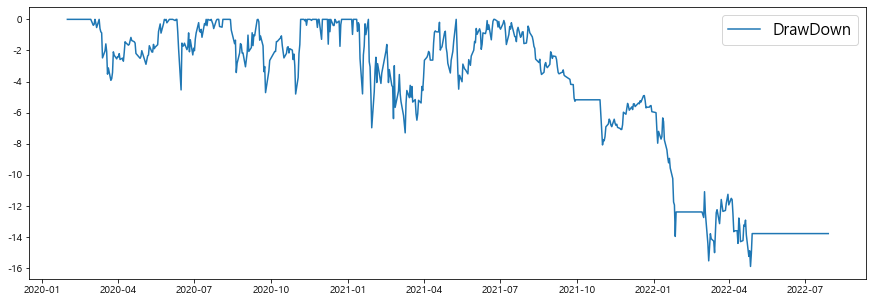

In [50]:
_, momentum6CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight6)

print(f"6개월 평균 모멘텀 스코어 최종수익률: {momentum6CumReturn.iloc[-1]}")
cagr6, dd6, mdd6 = getEvaluation(momentum6CumReturn)

**시장수익률 계산 (코스피200)**

In [45]:
rebalDate = getRebalancingDate(closeDataSet)

시장 최종수익률: 1.1892695824611657
최종 수익률 : 1.1892695824611657
cagr: 1.0731173954851394
mdd: 33.967353714206666


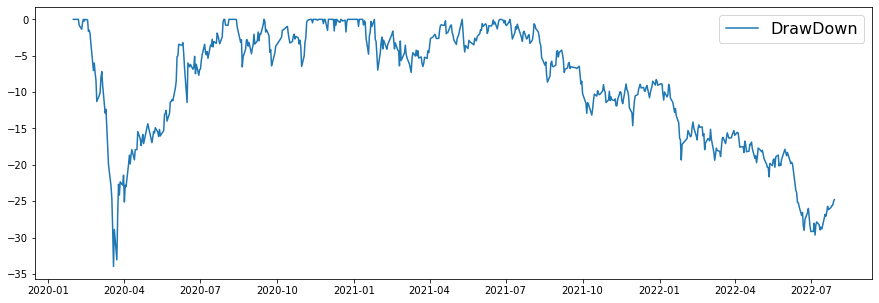

In [46]:
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"시장 최종수익률: {stockCumReturn.iloc[-1]}")
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

**시각화 비교**

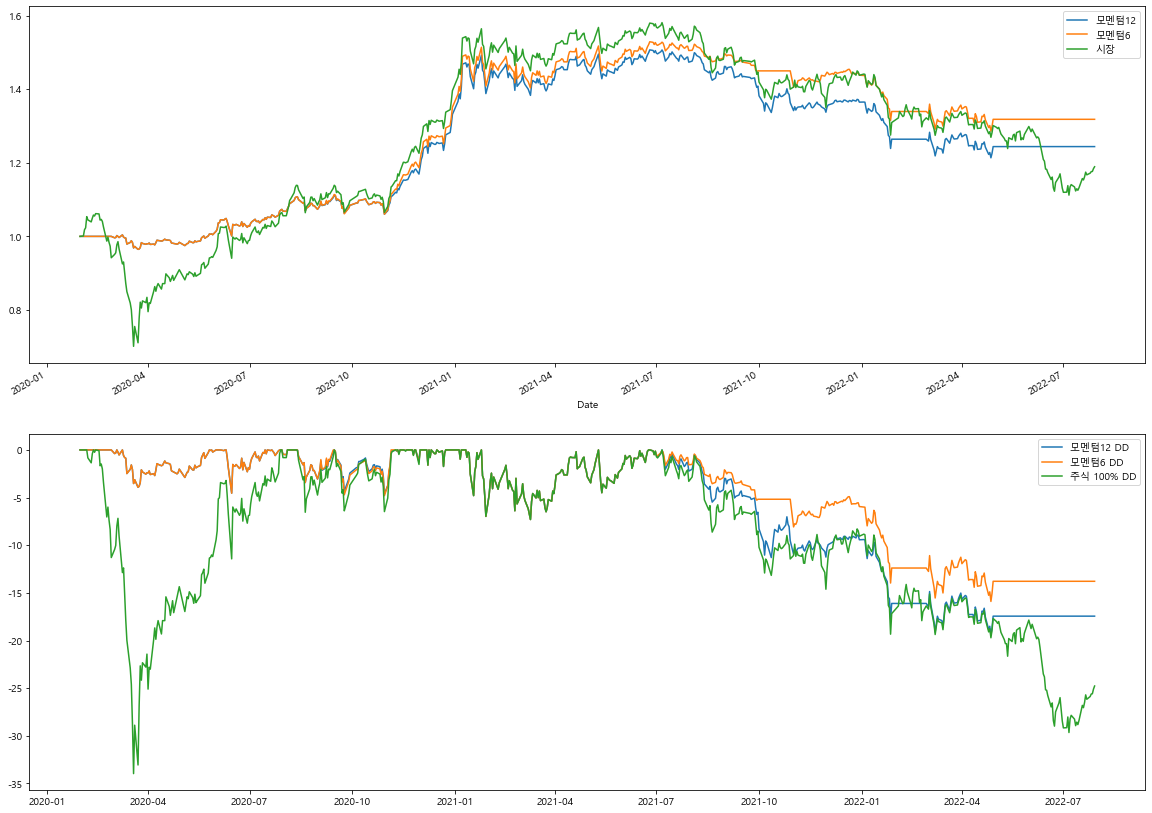

In [47]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="모멘텀12")
momentum6CumReturn.plot(label="모멘텀6")
stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-dd12, label="모멘텀12 DD")
plt.plot(-dd6, label="모멘텀6 DD")
plt.plot(-stockDD, label="주식 100% DD")
plt.legend()

plt.show()

In [5]:
kodex200 = getCloseData("069500", "2021-9-1")
kodex200

069500


Date
2021-09-01    41056
2021-09-02    40680
2021-09-03    40943
2021-09-06    41086
2021-09-07    40841
              ...  
2022-10-26    29397
2022-10-27    29910
2022-10-28    29525
2022-10-31    29965
2022-11-01    30275
Name: Close, Length: 286, dtype: int64

In [7]:
rebalDate = getRebalancingDate(kodex200)
priceOnRebalDate =  kodex200.loc[rebalDate]


In [14]:
avgMomentumScoretable1(priceOnRebalDate, 12)

,Close
Date,
2021-09-30,0
2021-10-29,0
2021-11-30,0
2021-12-30,2
2022-01-28,0
2022-02-28,1
2022-03-31,2
2022-04-29,0
2022-05-31,0
